In [837]:
import os
import pandas as pd
import numpy as np
from scipy import io
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import ExcelWriter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge


In [699]:
# #Read dataset from Github
# !pip install -q xlrd
# !git clone https://github.com/kishoret04/statisticallearning_datamining.git
# ##Files from the cloned git repository.
# !ls  statisticallearning_datamining/datasets

In [700]:
class KernelRidgePrediction:
    #attributes
        
    
    #methods
    def __init__(self,ds_filename):
        
        self.df_totaldata = pd.read_excel(ds_filename)
        self.df_totaldata_orig = self.df_totaldata.copy()
        #add Xp(j)=1 column
        self.df_totaldata.insert(11,'X11',np.repeat(1.,self.df_totaldata.shape[0]))
        self.f_size = (8,8)
        
    #missing value count
    def missingvalue_count(self): 
        
        #initiaizing severity dataframe with NaN values
        self.df_severity = pd.DataFrame(data = np.NaN,index = self.df_totaldata.columns,
                                  columns = ['Missing_Values','%_of_MV'])
        
        self.df_missingrec = pd.DataFrame()
        #iterating through columns to find null values count and percentage
        for column in self.df_totaldata:
            
            if self.df_totaldata[column].isnull().values.any():    
                
                null_rows = self.df_totaldata[column].isnull()        
                null_count = sum(null_rows)
                nullcount_percent = round(null_count/self.df_totaldata[column].size*100,2)        
                self.df_missingrec = self.df_missingrec.append(self.df_totaldata[null_rows])
            else:        
                
                null_count = 0
                nullcount_percent = 0   
            #saving missing value counts in dataframe
            self.df_severity.loc[column,'Missing_Values'] = null_count
            self.df_severity.loc[column,'%_of_MV'] = nullcount_percent    
        
        print('Data Severity\n ', self.df_severity)
      

    def create_traintestdata(self,prop):  

        #calculate trainset size for cl1
        train_size = int(prop*self.df_totaldata.shape[0]/100)
        #extract a random sample of 80% as train and 20% as test set
        self.df_train = self.df_totaldata.sample(train_size)
        self.df_test = self.df_totaldata.drop(self.df_train.index)

        #sort train and test by date
        self.df_train.sort_values(by='Date',ascending=True,axis =0,inplace=True)
        self.df_test.sort_values(by='Date',ascending=True,axis =0,inplace=True)
        #Reset index    
        self.df_train.reset_index(drop=True,inplace = True)
        self.df_test.reset_index(drop=True,inplace = True)
        
        
    def write_traintest_files(self,filepath):
        with ExcelWriter(filepath) as writer:
            self.df_train.to_excel(writer,sheet_name = 'train_data' )
            self.df_test.to_excel(writer,sheet_name = 'test_data' )
            self.df_train.loc[:,'X1':'X11'].to_excel(writer,sheet_name = 'train_data_nolabel' )
            self.df_train['Y'].to_excel(writer,sheet_name = 'train_labels_all' )
            self.df_test.loc[:,'X1':'X11'].to_excel(writer,sheet_name = 'test_data_nolabel' )
            self.df_test['Y'].to_excel(writer,sheet_name = 'test_labels_all' )
            writer.save()  
       

    def calc_kl_radial(self,gamma,x,y):    
        val_k = math.exp(-1*gamma*np.power(np.linalg.norm(x-y),2))
        return val_k

    ####Line vector calculation-----------
    def cal_linevector_A(self,val_gamma,val_lambda,df_train):    
        #gramian matrix
        mat_train = np.matrix(df_train.loc[:,'X1':'X11'])
        val_m =mat_train.shape[0]

        for i in np.arange(val_m):
            for j in np.arange(val_m):
                mat_gramian[i,j] = calc_kl_radial(val_gamma,mat_train[i],mat_train[j])

        #Calculation of M = G + lambda*Identity    
        mat_M = mat_gramian + val_lambda*np.eye(mat_gramian.shape[0])
        mat_Minv = np.linalg.inv(mat_M)

        #line vector A calculation
        mat_y = np.asmatrix(df_train['Y'])
        linevector_A = mat_y* mat_Minv

        return linevector_A

    #calculate prediction for input vector input_X
    def cal_predx(self,val_gamma,linevector_A,mat_input_X,mat_train_X):
        val_trainsize = mat_train_X.shape[0]  
        mat_vx = np.zeros(val_trainsize).reshape(val_trainsize,1)      

        for i in np.arange(val_trainsize):
            
            mat_vx[i,0] = calc_kl_radial(val_gamma,mat_input_X,mat_train_X[i])

        pred_x = linevector_A*mat_vx
        return np.around(pred_x[0,0],4)
    
    def cal_rmse(self,y_true,y_pred):
        val_rmse = np.sqrt(np.mean(np.square(y_true-y_pred)))
        return val_rmse   

    ###function to calculate performance for given test set and linevector_A
    def cal_performance_params(self,val_gamma,linevector_A,df_test,df_train):
        
        #matrix formulation
        mat_train = np.matrix(df_train.loc[:,'X1':'X11'])
        val_m =mat_train.shape[0]
        mat_test = np.matrix(df_test.loc[:,'X1':'X11'])
        val_testsize = mat_test.shape[0]  

        #calculate predictions for test data
        mat_pred_x = np.zeros(val_testsize).reshape(val_testsize,1)
        for i in np.arange(val_testsize):
            mat_pred_x[i,0] = cal_predx(val_gamma,linevector_A,mat_test[i],mat_train)


        #reshaping arguments for RMSE
        mat_y_true = np.asmatrix(df_test['Y'])
        mat_y_pred = np.asmatrix(np.array(mat_pred_x[:,0])).reshape(mat_y_true.shape)

        #calculate RMSE
        val_rmse_test = cal_rmse(mat_y_true,mat_y_pred)

        #calculate ratio RMSE/avy for test
        val_avy_test = np.mean(np.abs(mat_y_true))
        ratio_rmse_avy_test = np.around(val_rmse_test/val_avy_test,4)
        
        #rplotting true y vs yhat

        fig, ax = plt.subplots(figsize=self.f_size)
        ax.plot( [0,np.max(mat_y_true)],[0,np.max(mat_y_true)] )
        ax.scatter(np.asarray(mat_y_true),np.asarray(mat_y_pred),c = 'g')
        ax.set(title = 'y vs y hat ' , xlabel = 'y', ylabel = 'yhat')
        plt.show()
        
        #RMSE ratio and confidence intervals
        print('val_rmse: ',np.around(val_rmse_test,4))
        print('ratio rmse/avy : ',ratio_rmse_avy_test)
        confint_ratio = self.err_est_element(ratio_rmse_avy_test,df_test['Y'].shape[0],False)

        print('For 95% confidence level, confidence interval for ratio {0} is {1}'.format(
            ratio_rmse_avy_test,confint_ratio))


        return val_rmse_test,ratio_rmse_avy_test,mat_y_pred
    
    ####---------------------------------

    def tune_krr(self,tuned_parameters):
        lambda_range = tuned_parameters['lambda']
        gamma_range = tuned_parameters['gamma']
        df_grid_scores = pd.DataFrame(0,index = [],columns = 
                                    ['rmse_test','rmse_train','ratio_test','ratio_train',
                                     'diff_ratio','params'])

        #tuning output
        for val_lambda in lambda_range:
            for val_gamma in gamma_range:
                print('tuning parameters: lambda ={0},gamma = {1}'.format(val_lambda,val_gamma))
                linevector_A = cal_linevector_A(val_gamma,val_lambda,self.df_train)
                #train performance 
                print('#train performance')
                val_rmse_train,ratio_rmse_avy_train,mat_train_pred = cal_performance_params(val_gamma,linevector_A,self.df_train,self.df_train)

                #test performance
                print('#test performance')
                val_rmse_test,ratio_rmse_avy_test,mat_test_pred = cal_performance_params(val_gamma,linevector_A,self.df_test,self.df_train)      
                params = 'lambda = '+ str(val_lambda)+ '; gamma = '+ str(val_gamma)
                row = {'rmse_test':val_rmse_test,'rmse_train':val_rmse_train,
                       'ratio_test':ratio_rmse_avy_test,'ratio_train':ratio_rmse_avy_train,
                       'diff_ratio': ratio_rmse_avy_test -ratio_rmse_avy_train ,
                       'params':params }      
                df_grid_scores = df_grid_scores.append(row,ignore_index = True)
                
        df_grid_scores.to_excel('grid_scores.xlsx')

    def err_est_element(self,term,size,return_sigma):
        sigma = np.around(math.sqrt(term*(1-term)/size),4)
        print('sigma: ',sigma)
        #for 95% confidence level
        Z_VAL = 1.96
        limit_lower = np.around((term - Z_VAL*sigma),4)

        if limit_lower < 0:
            limit_lower = 0
            
        limit_upper = np.around((term + Z_VAL*sigma),4)
        
        if limit_upper > 100:
            limit_upper = 100
      
        conf_int = [limit_lower,limit_upper]
        
        if return_sigma:
            return sigma
        else:
            return str(conf_int)

    def plot_results(self,data,title):

        fig, ax = plt.subplots(figsize=self.f_size)
        data.plot('Date',['Y','yhat'],ax=ax)
        #ax.plot(np.arange(1,sort_linevect_A.shape[0]+1),sort_linevect_A, c='b',s=5, alpha=.5)
        ax.set(title = title , xlabel = 'Date', ylabel = 'stock price')
        plt.show()
        
    #calculate prediction coefficients list for input vector input_X
    def cal_predx_list(self,val_gamma,linevector_A,mat_input_X,mat_train_X):
        val_trainsize = mat_train_X.shape[0]  
        #reshaping with same
        mat_vx = np.zeros(val_trainsize).reshape(linevector_A.shape)      

        for i in np.arange(val_trainsize):
            #print('sizes: {0},{1}'.format(mat_input_X.shape,mat_train_X[i].shape))
            mat_vx[0,i] = calc_kl_radial(val_gamma,mat_input_X,mat_train_X[i])

        #print(' cal_predx variable mat_vx:\n',mat_vx)
        pred_x = np.multiply(linevector_A, mat_vx)
        #print('cal_predx variable pred_x: ',pred_x)
        return np.around(pred_x,4)         

    #function that returns list of elements in pred(x) summations in test set
    def cal_indices_pred(self,val_gamma,linevector_A,df_train,df_test):

        #matrix formulation
        mat_train = np.matrix(df_train.loc[:,'X1':'X11'])
        val_m =mat_train.shape[0]
        #mat_test_worst10 = np.matrix(df_test.loc[0:9,'X1':'X11'])
        mat_test_worst10 = np.matrix(df_test.loc[:,'X1':'X11'])
        val_testsize = mat_test_worst10.shape[0]  

        #calculate predictions for test data
        #mat_pred_x = np.zeros(val_testsize).reshape(val_testsize,linevector_A_best.shape[1])
        mat_pred_x = np.zeros((val_testsize,linevector_A.shape[1]))
        for i in np.arange(val_testsize):
            mat_pred_x[i] = cal_predx_list(val_gamma,linevector_A,mat_test_worst10[i],mat_train)

        #print('cal_performance_params variable mat_pred_x:\n',mat_pred_x)

        return mat_pred_x

    


# 1.1 make sure that p ≥ 10 in your Data Set and make sure to include an artificial feature Xp(j) =1 for all cases j=1...n
each feature must be a "continuous" variable; 
avoid or eliminate discrete features taking only a small number of values ; 



In [701]:
#Copy data into a dataframe
#ds_filename = 'statisticallearning_datamining/datasets/stocks_dataset.xlsx'
ds_filename = r'/Users/kishore/Google Drive/GRE/application/UoH DS/Fall 2019/MATH 6350 Statistical Learning and data mining/project/stocks_dataset.xlsx'
#ds_filename = r'C:\Users\kisho\Desktop\python_jupyter\stocks_dataset.xlsx'

krr_radial = KernelRidgePrediction(ds_filename)

krr_radial.df_totaldata.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
count,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.0,1228.000000
mean,46.380700,22.926686,83.768518,60.125138,88.068664,40.984511,152.268160,39.398819,65.506018,38.401254,1.0,54.423819
std,5.934820,6.335708,9.797095,10.279005,21.575374,8.318677,50.245238,8.830776,9.955754,6.782055,0.0,8.106937
min,32.740002,11.160000,58.150002,34.980000,53.070000,21.690001,80.769997,22.219999,43.250000,25.930000,1.0,34.340000
25%,41.230000,16.325000,77.320000,52.047501,65.777498,34.717500,105.275000,30.980000,57.297501,33.235002,1.0,49.130001
50%,46.640001,23.895000,83.790001,60.910000,90.559998,42.475000,145.650002,40.105001,64.839996,37.380001,1.0,54.265001
75%,51.882501,28.990000,90.982502,68.910002,108.667503,46.692499,193.994999,45.180000,73.940002,42.690001,1.0,59.969999
max,58.419998,33.259998,105.709999,80.080002,130.380005,58.910000,267.750000,59.590000,92.910004,55.490002,1.0,75.040001


# 1.4.for each feature X1 X2 ... Xp, compute and display its  mean and standard deviation

In [702]:
krr_radial.df_totaldata.describe().to_excel('df_totaldata.describe.xlsx')

# 1.5. compute and display its  mean and standard deviation for Y 


In [703]:
krr_radial.df_totaldata.describe()['Y']

count    1228.000000
mean       54.423819
std         8.106937
min        34.340000
25%        49.130001
50%        54.265001
75%        59.969999
max        75.040001
Name: Y, dtype: float64

# 1.6. Split the data set DS into a training set TRAIN and a test set TEST, with respective proportions 80% ,  20%

In [704]:
#missing values in each column
krr_radial.missingvalue_count()

Data Severity
        Missing_Values  %_of_MV
Date             0.0      0.0
X1               0.0      0.0
X2               0.0      0.0
X3               0.0      0.0
X4               0.0      0.0
X5               0.0      0.0
X6               0.0      0.0
X7               0.0      0.0
X8               0.0      0.0
X9               0.0      0.0
X10              0.0      0.0
X11              0.0      0.0
Y                0.0      0.0


In [705]:
#create train and test datasets
PROP = 80
#df_train,df_test,df_train_notarget,df_train_target,df_test_notarget,df_test_target = create_traintestdata(prop,df_totaldata.copy())
#df_train,df_test = create_traintestdata(PROP,df_totaldata.copy())
krr_radial.create_traintestdata(PROP)
#describe train and test data
print('############# Train data #######')

#write to excel dataset
filepath = 'preprocessed_data.xlsx'

krr_radial.write_traintest_files(filepath)

############# Train data #######


In [706]:
krr_radial.df_train.describe().to_excel('df_train.describe.xlsx')

In [707]:
krr_radial.df_test.describe().to_excel('df_test.describe.xlsx')

# 1.7.Compute the empirical correlations cor(X1, Y) ... cor(Xp,Y) and their absolute values C1 ... Cp
  


In [708]:
sr_corr_XY = pd.DataFrame(np.abs(krr_radial.df_totaldata.corrwith(krr_radial.df_totaldata['Y'])))
sr_corr_XY

,0
X1,0.738677
X2,0.633975
X3,0.720354
X4,0.798157
X5,0.564827
X6,0.825664
X7,0.380449
X8,0.664872
X9,0.558936
X10,0.254778


In [709]:
sr_corr_XY.to_excel('sr_corr_XY.xlsx')

# 1.8.compute  the 3 largest values among C1 ... Cp, to be denoted  Cu > Cv > Cw which are

In [710]:
sr_corr_XY.sort_values(by=0,ascending=False)[1:4]

,0
X6,0.825664
X4,0.798157
X1,0.738677


# 1.9.display separately the 3 scatter plots (Xu(j), Yj)  ,  (Xv(j), Yj)  , (Xw(j), Yj)  where j= 1...n

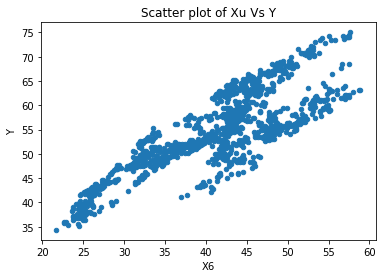

In [711]:
krr_radial.df_totaldata.plot(x='X6',y='Y',kind = 'scatter',title = 'Scatter plot of Xu Vs Y')

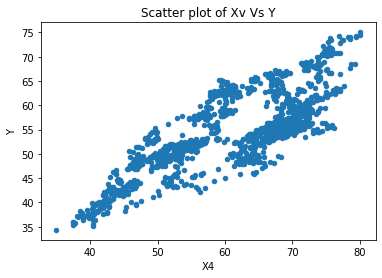

In [712]:
krr_radial.df_totaldata.plot(x='X4',y='Y',kind = 'scatter',title = 'Scatter plot of Xv Vs Y')

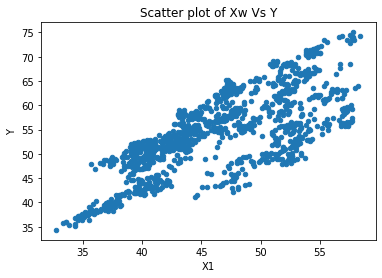

In [713]:
krr_radial.df_totaldata.plot(x='X1',y='Y',kind = 'scatter',title = 'Scatter plot of Xw Vs Y')

# Question 2: Kernel Ridge Regression (KRR) with radial kernel.For this question we use intensively the training set TRAIN which has size m = 80% n 


# 2.1.Compute the matrix G and its eigenvalues L1 >L2 > ... > Lm ≥ 0

In [714]:
#saving train data into matrix form
mat_train = np.matrix(krr_radial.df_train.loc[:,'X1':'X11'])
val_m =mat_train.shape[0]
mat_gramian = np.zeros((val_m,val_m))
#sample gamma
VAL_SAMPLE_GAMMA = 0.01

#calculate gramian matrix for train data
for i in np.arange(val_m):
    for j in np.arange(val_m):
        mat_gramian[i,j] = krr_radial.calc_kl_radial(VAL_SAMPLE_GAMMA,mat_train[i],mat_train[j])
        
print('Gramian: \n',mat_gramian)
#count of negative values in gramian
sum(sum(mat_gramian<0))

Gramian: 
 [[1.00000000e+000 8.01588146e-001 4.62638945e-001 ... 1.29985787e-150
  6.16707225e-155 2.44384420e-162]
 [8.01588146e-001 1.00000000e+000 8.44012593e-001 ... 7.95375829e-155
  4.01702185e-159 1.17237960e-166]
 [4.62638945e-001 8.44012593e-001 1.00000000e+000 ... 1.08360020e-158
  5.84014199e-163 1.31617238e-170]
 ...
 [1.29985787e-150 7.95375829e-155 1.08360020e-158 ... 1.00000000e+000
  8.47958696e-001 5.39092861e-001]
 [6.16707225e-155 4.01702185e-159 5.84014199e-163 ... 8.47958696e-001
  1.00000000e+000 7.88603480e-001]
 [2.44384420e-162 1.17237960e-166 1.31617238e-170 ... 5.39092861e-001
  7.88603480e-001 1.00000000e+000]]


0

In [715]:
#calculate and display eigen values statistics
gramian_eig_val,gramian_eig_vec = np.linalg.eig(mat_gramian)
gramian_eig_val = gramian_eig_val.real
gramian_eig_vec = gramian_eig_vec.real

pd.DataFrame(gramian_eig_val).describe()

,0
count,982.000000
mean,1.000000
std,4.233241
min,0.000007
25%,0.002255
50%,0.014994
75%,0.140263
max,53.376379


In [716]:
#sorting eigen values in descending order
gramian_eig_val[::-1].sort()
gramian_eig_val

array([5.33763786e+01, 4.77564270e+01, 4.06083177e+01, 3.89403252e+01,
       3.08329008e+01, 2.84150364e+01, 2.79895013e+01, 2.44871230e+01,
       2.42934625e+01, 2.29289086e+01, 2.21892922e+01, 2.10087445e+01,
       2.05672506e+01, 1.78287403e+01, 1.74715765e+01, 1.70446773e+01,
       1.64815095e+01, 1.62092354e+01, 1.60287372e+01, 1.49686528e+01,
       1.27998717e+01, 1.26721686e+01, 1.26651618e+01, 1.25018742e+01,
       1.21171752e+01, 1.18114741e+01, 1.16062161e+01, 1.13879488e+01,
       1.01948983e+01, 9.92296941e+00, 9.76236094e+00, 8.79970445e+00,
       8.58010122e+00, 8.44378854e+00, 8.13094660e+00, 7.52691244e+00,
       7.07388265e+00, 6.73611561e+00, 6.56126814e+00, 6.54396274e+00,
       6.23630188e+00, 5.97475398e+00, 5.96128071e+00, 5.87709980e+00,
       5.84342838e+00, 5.00322494e+00, 4.82485452e+00, 4.79658737e+00,
       4.74665613e+00, 4.55728035e+00, 4.48291007e+00, 4.36229892e+00,
       4.29053278e+00, 4.21268502e+00, 3.96687529e+00, 3.87474007e+00,
      

# 2.2.Plot Lj versus j

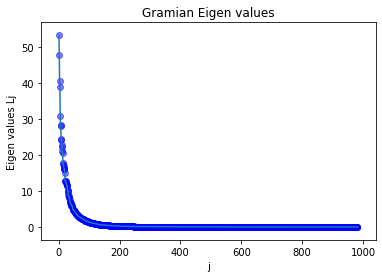

In [717]:
#plotting eigen values in descending order
fig, ax = plt.subplots()
ax.plot(np.arange(1,gramian_eig_val.shape[0]+1),gramian_eig_val,  '-')
ax.scatter(np.arange(1,gramian_eig_val.shape[0]+1),gramian_eig_val, c='b', alpha=.5)
ax.set(title = 'Gramian Eigen values', xlabel = 'j', ylabel = 'Eigen values Lj')
       #xticks = np.arange(1,gramian_eig_val.shape[0]+1))
       
plt.show()

# 2.3.Plot the increasing ratios RATj= (L1 + ... + Lj)/(L1+ ... + Lm)             #2.4.Identify the smallest j such that RATj ≥ 95% and set λ = Lj

In [718]:
ratio_eig_val = gramian_eig_val.cumsum()/gramian_eig_val.sum()
ratio_eig_val

array([0.05435476, 0.10298656, 0.14433923, 0.18399333, 0.21539139,
       0.24432728, 0.27282982, 0.29776579, 0.32250455, 0.34585375,
       0.36844977, 0.3898436 , 0.41078785, 0.42894339, 0.44673522,
       0.46409232, 0.48087594, 0.49738229, 0.51370483, 0.52894786,
       0.54198235, 0.5548868 , 0.56778411, 0.58051515, 0.59285443,
       0.60488241, 0.61670136, 0.62829805, 0.63867982, 0.64878468,
       0.65872598, 0.66768699, 0.67642436, 0.68502292, 0.69330291,
       0.70096779, 0.70817134, 0.71503092, 0.72171246, 0.72837637,
       0.73472699, 0.74081126, 0.74688181, 0.75286663, 0.75881717,
       0.76391211, 0.7688254 , 0.77370991, 0.77854357, 0.78318439,
       0.78774947, 0.79219173, 0.79656091, 0.80085081, 0.8048904 ,
       0.80883616, 0.81258997, 0.81620975, 0.81976125, 0.82322847,
       0.82658807, 0.82991794, 0.83314816, 0.83632585, 0.83937121,
       0.84233459, 0.84525769, 0.84812167, 0.85096304, 0.85372236,
       0.85638885, 0.85903244, 0.86166766, 0.86415942, 0.86656

In [719]:
# Where does Rj>.95
a_idx = np.where(ratio_eig_val>.95)[0][0] #gets the index
a = ratio_eig_val[a_idx] #gets the value at index
print('At eigenvalue', (a_idx+1), format(gramian_eig_val[a_idx], '.2f'), 'we get a ratio of', format(a, '.2%'))

val_lambda = gramian_eig_val[a_idx]
val_lambda

At eigenvalue 138 0.63 we get a ratio of 95.02%


0.6299551504277957

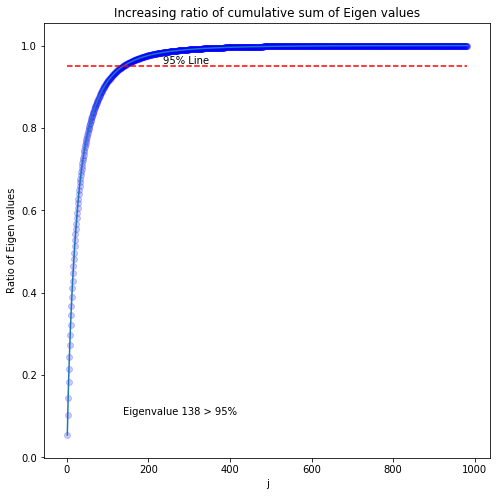

In [720]:
#plotting increasing ratio of eigen values to identify 95% eigen value
fig, ax = plt.subplots(figsize=krr_radial.f_size)
ax.plot(np.arange(1,gramian_eig_val.shape[0]+1),ratio_eig_val,  '-')
ax.scatter(np.arange(1,gramian_eig_val.shape[0]+1),ratio_eig_val, c='b', alpha=.2)

#ax.scatter(a_idx, a, c='green', alpha=1)
ax.plot(range(len(ratio_eig_val)), [.95]*gramian_eig_val.shape[0], 'r--', alpha=1)
ax.text(350,a,'95% Line', horizontalalignment = 'right', verticalalignment = 'bottom')
ax.text(a_idx,.1,'Eigenvalue {0} > 95%'.format(a_idx+1),
        horizontalalignment = 'left', verticalalignment = 'bottom')

ax.set(title = 'Increasing ratio of cumulative sum of Eigen values',
       xlabel = 'j', ylabel = 'Ratio of Eigen values')
      
       
plt.show()

# 2.5.Select at random two lists  List1 and List 2 of 100 random integers each , within   [1...m]

# 2.6.For all i in List 1 and all j in List2  compute Dij = ||X(i) -X(j)||



In [721]:
SIZE_SAMPLE = 100
df_list1 = krr_radial.df_train.loc[:,'X1':'X11'].sample(SIZE_SAMPLE).reset_index(drop=True)
df_list2 = krr_radial.df_train.loc[:,'X1':'X11'].sample(SIZE_SAMPLE).reset_index(drop=True)

mat_diff_dij = np.zeros(SIZE_SAMPLE*SIZE_SAMPLE).reshape(SIZE_SAMPLE,SIZE_SAMPLE)
for i in np.arange(df_list1.shape[0]):    
    for j in np.arange(df_list2.shape[0]):        
        mat_diff_dij[i,j] = np.around(np.linalg.norm(df_list1.loc[i,:] - df_list2.loc[j,:]),4)

arr_dij = mat_diff_dij.reshape(1,SIZE_SAMPLE*SIZE_SAMPLE)[0]
arr_dij

array([ 68.5795,  79.3454,  39.5088, ..., 156.5516, 121.0269, 171.5872])

# 2.7.Plot the histogram of the 10000 numbers Dij

# 2.8.Compute q =10% quantile of the 10000 numbers Dij

# 2.9.Set     gamma = 1/q

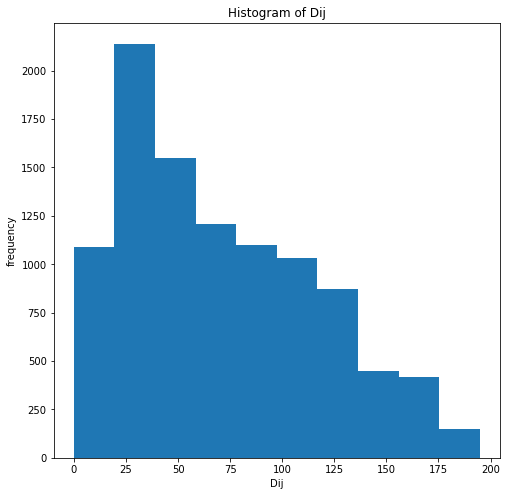

In [722]:
fig, ax = plt.subplots(figsize=krr_radial.f_size)
ax.hist(arr_dij)
ax.set(title = 'Histogram of Dij',
      xlabel = 'Dij', ylabel = 'frequency')
      #  xticks = np.arange(1,gramian_eig_val.shape[0]+1))
       
plt.show()

In [723]:
val_q = np.quantile(arr_dij,0.10)
val_gamma = 1/val_q
val_gamma

0.05448712360295014


# 2.9 Compute the matrix M = G + λ Id  and its inverse M-1  
# 2.10 As seen in class the prediction formula becomes pred(x) = A1 K(x, X(1)) + ... + Am K(x,X(m))compute the line vector A  = [A1 ... Am] by  A= y M-1   



In [724]:
linevector_A_sample = krr_radial.cal_linevector_A(val_gamma,val_lambda,krr_radial.df_train)
linevector_A_sample

matrix([[ 2.70636598e+01,  9.52012340e+00,  1.13154162e+01,
          4.72445461e+00,  1.19015891e+01,  1.25715365e+01,
          1.76543135e+01,  7.77906711e+00,  1.51480502e+01,
          9.61261480e+00,  5.06196841e+00,  4.55082918e+00,
          1.26059498e+01,  5.72154027e+00,  1.24765158e+01,
          1.69265476e+01,  6.34325850e+00,  9.16809867e+00,
          1.05395845e+01,  1.00661088e+01,  1.02851703e+01,
          1.09430357e+01,  5.80222910e+00,  6.93193863e-01,
          4.97660453e+00,  7.21767322e+00,  2.15702932e+00,
          4.65037481e+00,  8.16025358e+00,  3.91777150e+00,
          7.37107218e+00,  5.07615288e+00,  8.05988918e+00,
         -6.19690557e+00,  3.02611538e+00,  5.27363134e+00,
         -5.82628236e+00, -4.83327126e-01,  4.75933642e+00,
          7.31411269e+00,  1.69903091e+01, -3.96317375e+00,
          3.02283929e+00,  5.03685547e+00,  9.85883632e+00,
          5.86046587e+00,  9.06855215e+00,  2.70445929e+00,
         -2.66761743e+00,  7.16090112e-0

# 2.11 Compute the RMSEtrain  of the prediction function pred(x) by running it on all x in TRAIN set

##Train Performance for sample parameters###


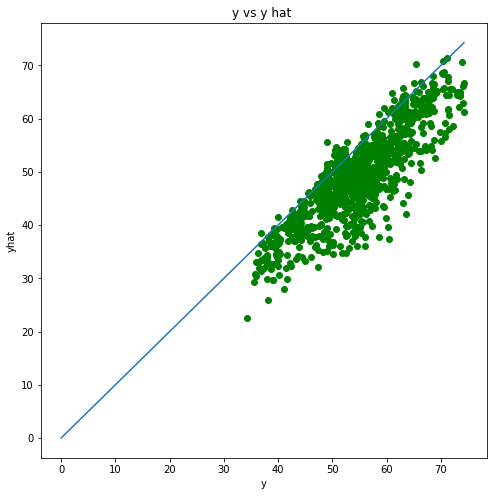

val_rmse:  7.078
ratio rmse/avy :  0.13
sigma:  0.0107
For 95% confidence level, confidence interval for ratio 0.13 is [0.109, 0.151]


In [725]:
#train performance 
print('##Train Performance for sample parameters###')
val_rmse_train,ratio_rmse_avy_train,mat_y_pred_train = krr_radial.cal_performance_params(
    val_gamma,linevector_A_sample,krr_radial.df_train,krr_radial.df_train)

# 2.12.Compute the RMSEtest   of the prediction function pred(x) by running it on all x in TEST set 


# 2.13 Compare these two RMSE values , and compute their ratios RMSE/ avy where avy = mean of the m absolute values |Y1|,  ... , |Ym|


####test performance for sample parameters####


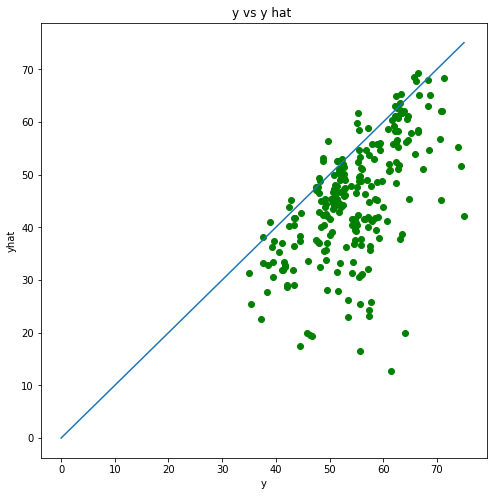

val_rmse:  12.9498
ratio rmse/avy :  0.2384
sigma:  0.0272
For 95% confidence level, confidence interval for ratio 0.2384 is [0.1851, 0.2917]


In [726]:
#test performance for sample parameters
print('####test performance for sample parameters####')
val_rmse_test,ratio_rmse_avy_test,mat_y_pred_test = krr_radial.cal_performance_params(
    val_gamma,linevector_A_sample,krr_radial.df_test,krr_radial.df_train)

# Question 3: Improving the results through step by step tuning

# 3.1.Repeat the preceding operations for other pairs of parameters gamma and λ 
Suggestion: change only one parameter at a time to check in which direction to go for improved performances


# 3.2.Select the best choice of parameters in terms of accuracy RMSE/avy and stability of performance when one goes from TRAIN to TEST set


tuning parameters: gamma = 0.05448712360295014,lambda =0.6299551504277957


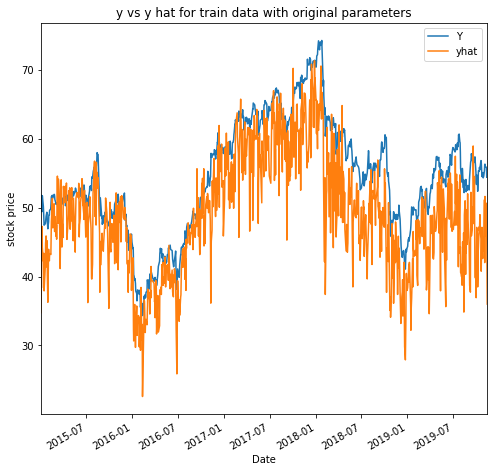

In [727]:
#results from question 2 params

print('tuning parameters: gamma = {0},lambda ={1}'.format(val_gamma,val_lambda))

#adding train prediction column to train dataset copy
df_train_orig_lv = krr_radial.df_train.copy()
df_train_orig_lv['yhat'] = np.asarray(mat_y_pred_train.T)


krr_radial.plot_results(df_train_orig_lv,title= 'y vs y hat for train data with original parameters')

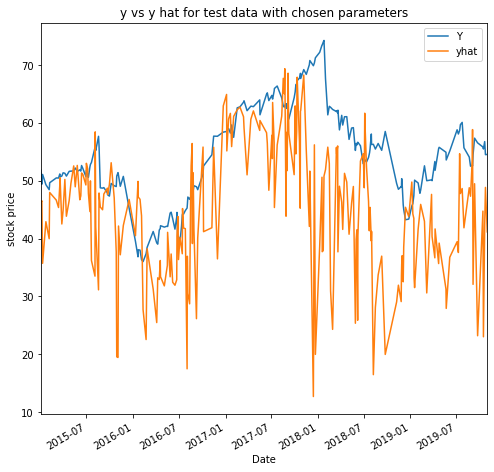

In [728]:
#adding test prediction column to test dataset copy
df_test_orig_lv = df_test.copy()
df_test_orig_lv['yhat'] = np.asarray(mat_y_pred_test.T)

krr_radial.plot_results(df_test_orig_lv,title= 'y vs y hat for test data with chosen parameters')

In [729]:
#first set  of values
gamma_0 = round(val_gamma,4)
lambda_0 = round(val_lambda,4)
#results from question 2 params
lambda_range = [lambda_0]
gamma_range = [gamma_0]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.63,gamma = 0.0545
#train performance
val_rmse_test:  7.0792
ratio rmse/avy:  0.13
#test performance
val_rmse_test:  12.9522
ratio rmse/avy:  0.2384


In [730]:
#tuning with lambda fixed and changing gamma
lambda_range = [lambda_0]
gamma_range = [gamma_0/2,2*gamma_0]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.63,gamma = 0.02725
#train performance
val_rmse_test:  4.8703
ratio rmse/avy:  0.0894
#test performance
val_rmse_test:  7.6848
ratio rmse/avy:  0.1415
tuning parameters: lambda =0.63,gamma = 0.109
#train performance
val_rmse_test:  9.8479
ratio rmse/avy:  0.1809
#test performance
val_rmse_test:  20.4666
ratio rmse/avy:  0.3767


In [731]:
gamma_1 = gamma_0/2
#tuning with gamma fixed and changing lambda
lambda_range = [lambda_0/2,2*lambda_0]
gamma_range = [gamma_1]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#krr_radial.tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.315,gamma = 0.02725
#train performance
val_rmse_test:  3.0887
ratio rmse/avy:  0.0567
#test performance
val_rmse_test:  6.1471
ratio rmse/avy:  0.1132
tuning parameters: lambda =1.26,gamma = 0.02725
#train performance
val_rmse_test:  7.7442
ratio rmse/avy:  0.1422
#test performance
val_rmse_test:  10.2378
ratio rmse/avy:  0.1885


In [732]:
lambda_1 = lambda_0/2
#tuning with gamma fixed and changing lambda
lambda_range = [lambda_1]
gamma_range = [gamma_1/2,2*gamma_1]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.315,gamma = 0.013625
#train performance
val_rmse_test:  2.265
ratio rmse/avy:  0.0416
#test performance
val_rmse_test:  3.6635
ratio rmse/avy:  0.0674
tuning parameters: lambda =0.315,gamma = 0.0545
#train performance
val_rmse_test:  4.2812
ratio rmse/avy:  0.0786
#test performance
val_rmse_test:  10.8173
ratio rmse/avy:  0.1991


In [733]:
gamma_2 = gamma_1/2
#tuning with gamma fixed and changing lambda
lambda_range = [lambda_1/2,2*lambda_1]
gamma_range = [gamma_2]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.1575,gamma = 0.013625
#train performance
val_rmse_test:  1.5898
ratio rmse/avy:  0.0292
#test performance
val_rmse_test:  3.0209
ratio rmse/avy:  0.0556
tuning parameters: lambda =0.63,gamma = 0.013625
#train performance
val_rmse_test:  3.3362
ratio rmse/avy:  0.0613
#test performance
val_rmse_test:  4.6507
ratio rmse/avy:  0.0856


In [734]:
lambda_2 = lambda_1/2
#tuning with lambda fixed and changing gamma
lambda_range = [lambda_2]
gamma_range = [gamma_2/2,2*gamma_2]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.1575,gamma = 0.0068125
#train performance
val_rmse_test:  1.2792
ratio rmse/avy:  0.0235
#test performance
val_rmse_test:  1.9588
ratio rmse/avy:  0.0361
tuning parameters: lambda =0.1575,gamma = 0.02725
#train performance
val_rmse_test:  1.9963
ratio rmse/avy:  0.0367
#test performance
val_rmse_test:  5.2031
ratio rmse/avy:  0.0958


In [735]:
gamma_3 = gamma_2/2
#tuning with gamma fixed and changing lambda
lambda_range = [lambda_2/2,2*lambda_2]
gamma_range = [gamma_3]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.07875,gamma = 0.0068125
#train performance
val_rmse_test:  0.9746
ratio rmse/avy:  0.0179
#test performance
val_rmse_test:  1.6448
ratio rmse/avy:  0.0303
tuning parameters: lambda =0.315,gamma = 0.0068125
#train performance
val_rmse_test:  1.7217
ratio rmse/avy:  0.0316
#test performance
val_rmse_test:  2.3916
ratio rmse/avy:  0.044


In [736]:
lambda_3 = lambda_2/2
#tuning with lambda fixed and changing gamma
lambda_range = [lambda_3]
gamma_range = [gamma_3/2,2*gamma_3]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.07875,gamma = 0.00340625
#train performance
val_rmse_test:  0.8568
ratio rmse/avy:  0.0157
#test performance
val_rmse_test:  1.1989
ratio rmse/avy:  0.0221
tuning parameters: lambda =0.07875,gamma = 0.013625
#train performance
val_rmse_test:  1.1362
ratio rmse/avy:  0.0209
#test performance
val_rmse_test:  2.5656
ratio rmse/avy:  0.0472


In [737]:
gamma_4 = gamma_3/2
#tuning with gamma fixed and changing lambda
lambda_range = [lambda_3/2,2*lambda_3]
gamma_range = [gamma_4]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.039375,gamma = 0.00340625
#train performance
val_rmse_test:  0.6953
ratio rmse/avy:  0.0128
#test performance
val_rmse_test:  1.031
ratio rmse/avy:  0.019
tuning parameters: lambda =0.1575,gamma = 0.00340625
#train performance
val_rmse_test:  1.0827
ratio rmse/avy:  0.0199
#test performance
val_rmse_test:  1.4249
ratio rmse/avy:  0.0262


In [738]:
lambda_4 = lambda_3/2
#tuning with lambda fixed and changing gamma
lambda_range = [lambda_4]
gamma_range = [gamma_4/2,2*gamma_4]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
#tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.039375,gamma = 0.001703125
#train performance
val_rmse_test:  0.7185
ratio rmse/avy:  0.0132
#test performance
val_rmse_test:  0.9658
ratio rmse/avy:  0.0178
tuning parameters: lambda =0.039375,gamma = 0.0068125
#train performance
val_rmse_test:  0.75
ratio rmse/avy:  0.0138
#test performance
val_rmse_test:  1.401
ratio rmse/avy:  0.0258


In [739]:
gamma_5 = gamma_4/2
#tuning with gamma fixed and changing lambda
lambda_range = [lambda_4/2,2*lambda_4]
gamma_range = [gamma_5]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
# tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.0196875,gamma = 0.001703125
#train performance
val_rmse_test:  0.615
ratio rmse/avy:  0.0113
#test performance
val_rmse_test:  0.8543
ratio rmse/avy:  0.0157
tuning parameters: lambda =0.07875,gamma = 0.001703125
#train performance
val_rmse_test:  0.8561
ratio rmse/avy:  0.0157
#test performance
val_rmse_test:  1.1077
ratio rmse/avy:  0.0204


In [740]:
lambda_5 = lambda_4/2
#tuning with lambda fixed and changing gamma
lambda_range = [lambda_5]
gamma_range = [gamma_5/2,2*gamma_5]
tuned_parameters = {'lambda': lambda_range, 'gamma': gamma_range}
# tune_krr(tuned_parameters,df_train,df_test)
krr_radial.tune_krr(tuned_parameters)

tuning parameters: lambda =0.0196875,gamma = 0.0008515625
#train performance
val_rmse_test:  0.7349
ratio rmse/avy:  0.0135
#test performance
val_rmse_test:  0.9641
ratio rmse/avy:  0.0177
tuning parameters: lambda =0.0196875,gamma = 0.00340625
#train performance
val_rmse_test:  0.5729
ratio rmse/avy:  0.0105
#test performance
val_rmse_test:  0.9003
ratio rmse/avy:  0.0166


# 3.3. Identify the 10  cases in the TEST set for which the squared prediction error is the largest 


In [792]:
# best_params = {'lambda': [0.0205], 'gamma': [0.0017]}
#best_params = {'lambda': [0.0209], 'gamma': [0.0017]}
best_params = {'lambda': [0.0197], 'gamma': [0.0017]}

####train performance for best parameters####


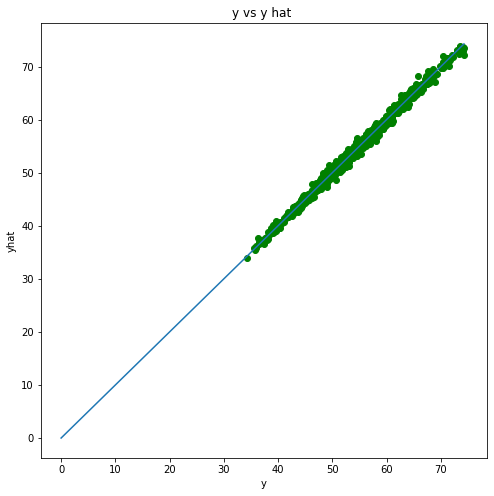

val_rmse:  0.6153
ratio rmse/avy :  0.0113
sigma:  0.0034
For 95% confidence level, confidence interval for ratio 0.0113 is [0.0046, 0.018]


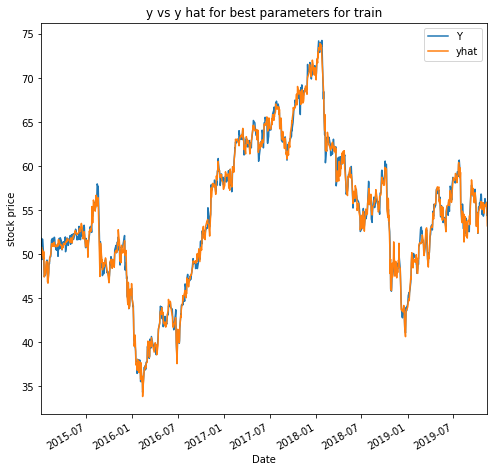

In [793]:
#train performance for best parameters
print('####train performance for best parameters####')
#calc linevector_A for  best params
linevector_A_best = krr_radial.cal_linevector_A(best_params['gamma'][0],best_params['lambda'][0],krr_radial.df_train)

#calc y_predictions
val_rmse_train_best,ratio_rmse_avy_train_best,mat_y_pred_train_best = krr_radial.cal_performance_params(
    best_params['gamma'][0],linevector_A_best,krr_radial.df_train,krr_radial.df_train)

df_train_best_lv = krr_radial.df_train.copy()
df_train_best_lv['yhat'] = np.asarray(mat_y_pred_train_best.T)

krr_radial.plot_results(df_train_best_lv,title= 'y vs y hat for best parameters for train')

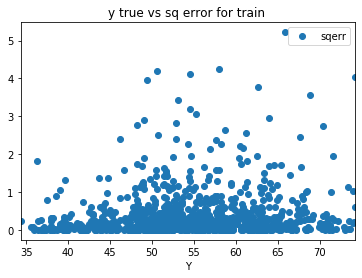

In [794]:
#train data - true vs error plot
df_train_best_lv['sqerr'] = np.asarray(np.square(df_train_best_lv['Y']-df_train_best_lv['yhat']))
df_train_best_lv.plot('Y','sqerr',style='o',title = 'y true vs sq error for train ')


####test performance for best parameters####


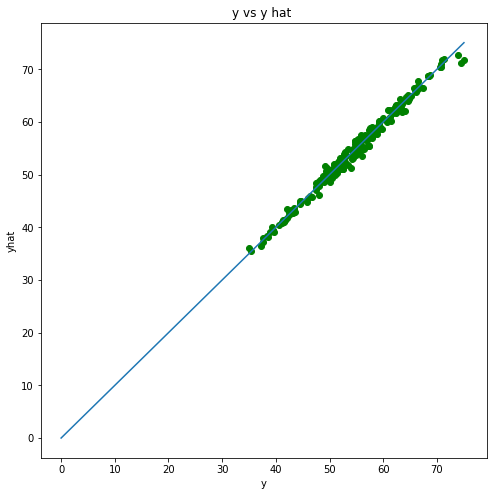

val_rmse:  0.8545
ratio rmse/avy :  0.0157
sigma:  0.0079
For 95% confidence level, confidence interval for ratio 0.0157 is [0.0002, 0.0312]


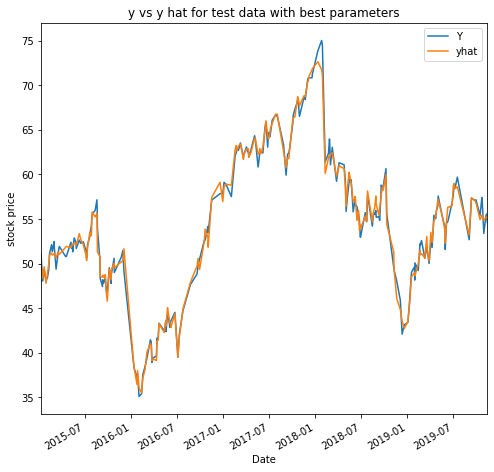

In [795]:
#test performance for best parameters
print('####test performance for best parameters####')

#calc y_predictions for test data for best params
val_rmse_test_best,ratio_rmse_avy_test_best,mat_y_pred_test_best = krr_radial.cal_performance_params(
    best_params['gamma'][0],linevector_A_best,krr_radial.df_test,krr_radial.df_train)

df_test_best_lv = krr_radial.df_test.copy()
df_test_best_lv['yhat'] = np.asarray(mat_y_pred_test_best.T)

krr_radial.plot_results(df_test_best_lv,title= 'y vs y hat for test data with best parameters')

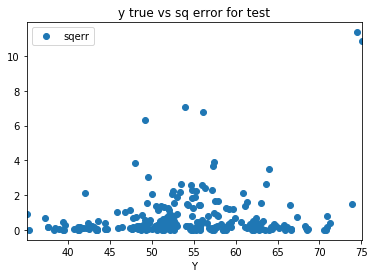

In [796]:
#test data - true vs error plot
df_test_best_lv['sqerr'] = np.asarray(np.square(df_test_best_lv['Y']-df_test_best_lv['yhat']))
df_test_best_lv.plot('Y','sqerr',style='o',title = 'y true vs sq error for test')

In [797]:
#calc squared pred error and top 10 largest error cases
#reshaping arguments for RMSE
mat_y_true = np.asmatrix(df_test['Y'])
df_test_error = df_test.copy()
df_test_error['yhat'] = df_test_best_lv['yhat']
df_test_error['sqerr'] = np.asarray(np.square(mat_y_pred_test_best-mat_y_true))[0]
#sqerror_top10 = np.asarray(-np.sort(-np.square(mat_y_pred-mat_y_true))[0,:10])[0]
df_test_error.sort_values(by = ['sqerr'],ascending =False,axis=0,inplace=True)

In [798]:
df_test_error.reset_index(inplace=True,drop=True)
df_test_error

,Date,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y,yhat,sqerr
0,2016-02-04,34.950001,13.250000,63.730000,40.790001,58.400002,25.010000,87.000000,24.969999,46.310001,33.790001,1.0,36.340000,51.6556,234.567599
1,2018-01-22,57.720001,31.940001,105.489998,78.589996,114.330002,57.360001,182.149994,55.439999,78.870003,45.349998,1.0,73.970001,59.7953,200.922155
2,2018-09-24,52.369999,30.740000,97.629997,73.839996,116.720001,48.560001,210.300003,51.560001,78.820000,32.340000,1.0,58.520000,44.8414,187.104110
3,2016-01-21,34.310001,13.360000,61.180000,40.150002,55.250000,24.780001,81.769997,24.379999,48.419998,33.209999,1.0,36.840000,50.2151,178.893296
4,2018-01-25,56.849998,32.090000,104.260002,79.440002,115.699997,56.810001,181.889999,54.180000,80.300003,45.160000,1.0,74.260002,60.9734,176.533796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2017-02-27,47.110001,24.570000,93.660004,60.020000,90.430000,45.840000,129.990005,41.730000,71.629997,43.369999,1.0,62.779999,62.8773,0.009468
242,2015-06-17,43.150002,17.370001,87.839996,56.540001,68.139999,39.580002,104.040001,33.070000,58.139999,50.799999,1.0,52.130001,52.0508,0.006273
243,2015-05-18,43.470001,16.510000,84.559998,54.669998,66.419998,38.330002,107.220001,31.860001,59.799999,52.099998,1.0,52.200001,52.1467,0.002841
244,2015-03-31,40.240002,15.390000,78.820000,51.520000,60.580002,35.689999,103.400002,30.440001,56.349998,51.320000,1.0,51.369999,51.3182,0.002683


In [799]:
df_test_error.to_excel('df_test_error.xlsx')

# 3.4.Vizualise the 10 cases by performing a PCA analysis and projecting all the TEST cases onto the first 3 principal eigenvectors of the PCA correlation matrix 


In [800]:
#PCA analysis and projection to 3 components
pca = PCA(n_components=3)
#fit train data
print("--------PCA Train data--------")
df_test_error_reduced = pca.fit_transform(df_test_error.loc[:,'X1':'X11'])  
df_test_error_reduced = pd.DataFrame(df_test_error_reduced)
print('explained_variance_ratio :', np.around(np.sum(pca.explained_variance_ratio_),2) )
filepath = 'df_test_error_reduced.xlsx'
with ExcelWriter(filepath) as writer:
    df_test_error_reduced.to_excel(writer,sheet_name = 'df_test_error_reduced' )
    df_test_error.to_excel(writer,sheet_name = 'df_test_error' )
    writer.save()  

--------PCA Train data--------
explained_variance_ratio : 0.99


In [801]:
size_testerr = df_test_error_reduced.shape[0]

cases_lowerror = np.arange((size_testerr-10),size_testerr)
cases_lowerror

array([236, 237, 238, 239, 240, 241, 242, 243, 244, 245])

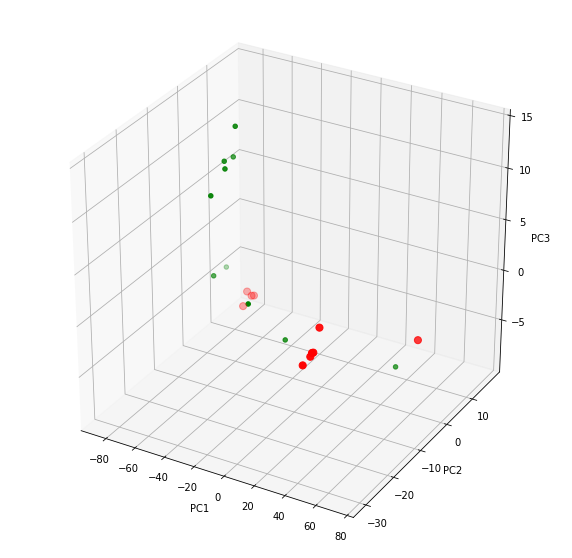

In [802]:
size_testerr = df_test_error_reduced.shape[0]
cases_lowerror = np.arange((size_testerr-10),size_testerr)

threedee = plt.figure(figsize=(10,10)).gca(projection='3d')
threedee.scatter(df_test_error_reduced.loc[0:9,0],
                 df_test_error_reduced.loc[0:9,1], 
                 df_test_error_reduced.loc[0:9,2],c='r',s=50)
threedee.scatter(df_test_error_reduced.loc[cases_lowerror,0],
                 df_test_error_reduced.loc[cases_lowerror,1],
                 df_test_error_reduced.loc[cases_lowerror,2],c='g')
threedee.set_xlabel('PC1')
threedee.set_ylabel('PC2')
threedee.set_zlabel('PC3')
plt.show()


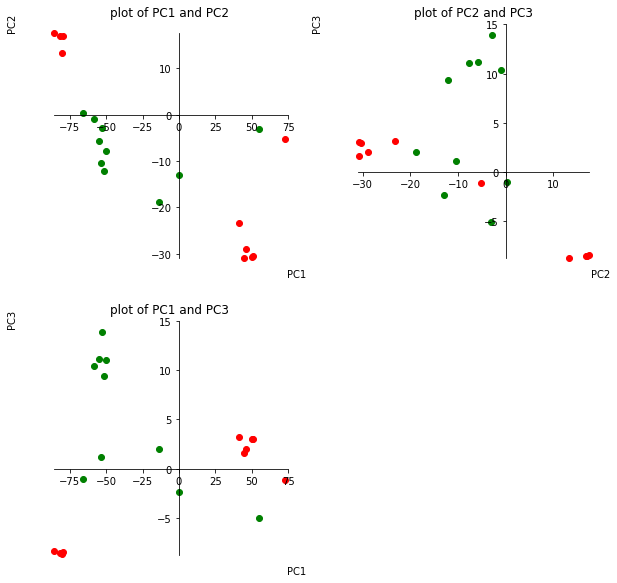

In [803]:
fig = plt.figure(figsize=(10,10))
#plot of PC1 and PC2
ax1 = fig.add_subplot(2,2,1)
ax1 = plot_setspines(ax1)
ax1.scatter(df_test_error_reduced.loc[0:9,0],df_test_error_reduced.loc[0:9,1],color='r')
ax1.scatter(df_test_error_reduced.loc[cases_lowerror,0],df_test_error_reduced.loc[cases_lowerror,1],color='g')
ax1.set(title = 'plot of PC1 and PC2',xlabel = 'PC1', ylabel = 'PC2')


#plot of PC2 and PC3
ax2 = fig.add_subplot(2,2,2)
ax2 = plot_setspines(ax2)
ax2.scatter(df_test_error_reduced.loc[0:9,1],df_test_error_reduced.loc[0:9,2],color='r')
ax2.scatter(df_test_error_reduced.loc[cases_lowerror,1],df_test_error_reduced.loc[cases_lowerror,2],color='g')
ax2.set(title = 'plot of PC2 and PC3',xlabel = 'PC2', ylabel = 'PC3')


#plot of PC1 and PC3
ax3 = fig.add_subplot(2,2,3)
ax3 = plot_setspines(ax3)
ax3.scatter(df_test_error_reduced.loc[0:9,0],df_test_error_reduced.loc[0:9,2],color='r')
ax3.scatter(df_test_error_reduced.loc[cases_lowerror,0],df_test_error_reduced.loc[cases_lowerror,2],color='g')
ax3.set(title = 'plot of PC1 and PC3',xlabel = 'PC1', ylabel = 'PC3')

plt.show()



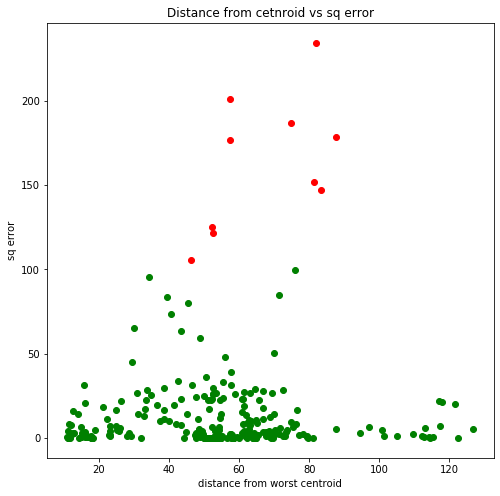

In [804]:
#calculate centroid of 10 worst cases
centroid_worst = np.sum(df_test_error.loc[:9,'X1':'X11' ])/10
centroid_worst

#distance between centroid and each case
df_test_error['Dn_centr_w'] = np.linalg.norm(df_test_error.loc[:,'X1':'X11']- centroid_worst, axis=1)
df_test_error

#scatterplot of distances
fig, ax = plt.subplots(figsize=krr_radial.f_size)
ax.plot(df_test_error.loc[0:9,'Dn_centr_w'],df_test_error.loc[0:9,'sqerr'],'ro')
ax.plot(df_test_error.loc[cases_lowerror,'Dn_centr_w'],df_test_error.loc[cases_lowerror,'sqerr'],'go')
ax.plot(df_test_error.loc[10:,'Dn_centr_w'],df_test_error.loc[10:,'sqerr'],'go')
ax.set(title = 'Distance from cetnroid vs sq error',xlabel = 'distance from worst centroid',
       ylabel = 'sq error')

plt.show()

# 3.5.Try to identify what went wrong with the prediction of the absolute worse case X(w) by looking at the terms involved in pred(Xw) and comparing to another case where the prediction erro is really small


In [805]:
print(df_test_error.loc[0:9])
print('least error: \n',df_test_error.loc[(df_test_error.shape[0]-2) :])


        Date         X1         X2          X3         X4          X5  \
0 2016-02-04  34.950001  13.250000   63.730000  40.790001   58.400002   
1 2018-01-22  57.720001  31.940001  105.489998  78.589996  114.330002   
2 2018-09-24  52.369999  30.740000   97.629997  73.839996  116.720001   
3 2016-01-21  34.310001  13.360000   61.180000  40.150002   55.250000   
4 2018-01-25  56.849998  32.090000  104.260002  79.440002  115.699997   
5 2016-01-29  36.220001  14.140000   65.620003  42.580002   59.500000   
6 2016-01-22  35.150002  13.560000   61.099998  41.060001   56.950001   
7 2018-01-17  57.889999  31.180000  104.389999  77.470001  112.989998   
8 2018-01-18  55.349998  31.480000  103.410004  77.389999  113.260002   
9 2018-01-08  55.060001  30.120001  100.800003  74.529999  108.500000   

          X6          X7         X8         X9        X10  X11          Y  \
0  25.010000   87.000000  24.969999  46.310001  33.790001  1.0  36.340000   
1  57.360001  182.149994  55.439999  78.87

In [806]:
df_test_error.to_excel('df_test_error.xlsx')

# 3.6 worst case analysis
pred(x) = A1 K(x, X(1)) + ... + Am K(x,X(m)) = U1 + ... +Um

consider the list LIST(x) of positive  numbers V(1)= |U1| ... V(m) = |Um|

find the sublist LIST5(x) of the 5 largest numbers in LISTx , and denote them

V(m1) > V(m2) > V(m3)) > V(m4) > V(m5) 

Do this for x = worst test case  to get  [m1 m2 m3 m4 m5]

Do this for x = good test case  to get  [M1 M2 M3 M4 M5] 

compare 
[m1 m2 m3 m4 m5] and [M1 M2 M3 M4 M5] 

repeat this comparison for a  few more good cases to check if you find  interpretable patterns of indices 
you can also apply the same method of sublists extraction  to the list  of positive  numbers W(1)= K(x,X(1)) ... W(m) = K(x,X(m)) 



In [807]:
best_params

{'lambda': [0.0197], 'gamma': [0.0017]}

In [808]:
#worst 10 cases indices in pred(x)
mat_pred_worst10 = krr_radial.cal_indices_pred(best_params['gamma'][0],linevector_A_best,
                              krr_radial.df_train,df_test_error.loc[0:9])

#calculate indices of highest Ui values in pred_x summation for worst 10 cases
mat_list_indices_worst10 = np.argsort(-np.abs(mat_pred_worst10))[:,0:5]
print('mat_list_indices_worst:\n',mat_list_indices_worst10)

mat_list_indices_worst:
 [[213 124 201 209 229]
 [621 623 627 599 620]
 [742 718 745 736 703]
 [213 209 201 124 229]
 [621 623 627 599 620]
 [213 124 201 209 125]
 [213 124 201 209 229]
 [621 623 599 627 612]
 [621 623 599 627 612]
 [621 599 623 627 612]]


In [809]:
pd.DataFrame(mat_list_indices_worst10).to_excel('mat_list_indices_worst10.xlsx')

In [810]:
#best 10 cases indices in pred(x)
req_index = (df_test_error.shape[0]-10)
mat_pred_best10 = cal_indices_pred(best_params['gamma'][0],linevector_A_best,
                              krr_radial.df_train,df_test_error.loc[ req_index: ])

#calculate indices of highest Ui values in pred_x summation for worst 10 cases
mat_list_indices_best10 = np.argsort(-np.abs(mat_pred_best10))[:,0:5]
print('mat_pred_best10:\n',mat_list_indices_best10)


mat_pred_best10:
 [[124 176 121 125 177]
 [499 571 500 510 501]
 [121  36  53 123  34]
 [121 123  36 120  84]
 [673 703 775 759 656]
 [438 499 482 423 397]
 [121 123  84 120 122]
 [121 123  84 120  36]
 [121 124  36  34 176]
 [121 123 120 176 122]]


In [811]:
pd.DataFrame(mat_list_indices_best10).to_excel('mat_list_indices_best10.xlsx')


# Question 4 : Analysis of the best predicting formula pred(x)

# 4.1. Fix the best choice of parameters as found in the preceding question. 


# 4.2. reorder the |A1|, |A2|, ....|Am| in decreasing order , which gives a list B1 > B2 ... > Bm  >0 and plot the decreasing curve Bj versus j


In [812]:
pd.DataFrame(np.asarray(linevector_A_best[0:10])[0]).to_excel('linevector_A_best.xlsx')

In [813]:
(linevector_A_best[0:10])[0].shape

(1, 982)

In [814]:
best_params

{'lambda': [0.0197], 'gamma': [0.0017]}

In [815]:
#sorting in descending order
sort_linevector_A_best = np.asarray(np.abs(linevector_A_best))[0]
sort_linevector_A_best[::-1].sort()

In [816]:
sort_linevector_A_best[0:10]

array([115.95905311, 104.72594964, 103.94086735, 103.05001243,
       102.05630326, 100.98301801,  98.53507034,  95.8401343 ,
        94.06094418,  90.60757471])

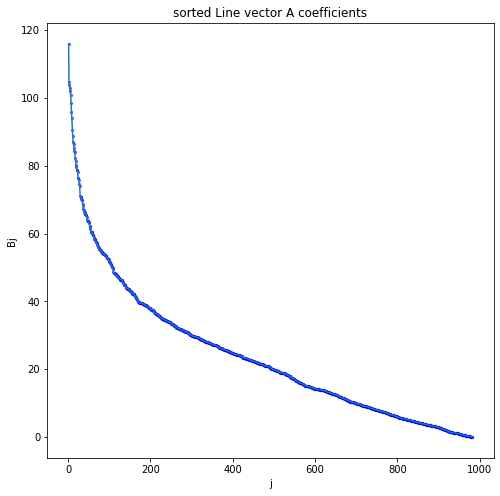

In [817]:
fig, ax = plt.subplots(figsize=krr_radial.f_size)

ax.plot(np.arange(1,sort_linevector_A_best.shape[0]+1),sort_linevector_A_best,  '-')
ax.scatter(np.arange(1,sort_linevector_A_best.shape[0]+1),sort_linevector_A_best, c='b',s=5, alpha=.5)
ax.set(title = 'sorted Line vector A coefficients', xlabel = 'j', ylabel = 'Bj')
       
plt.show()

# 4.3.Compute the ratios bj = (B1 + ... + Bj)/(B1 + ...+Bm)and plot the increasing curve bj versus j


In [818]:
ratio_sorted_lv_A = sort_linevector_A_best.cumsum()/sort_linevector_A_best.sum()
# Where does Bj>.99
a_idx = np.where(ratio_sorted_lv_A>.99)[0][0] #gets the index
a = ratio_sorted_lv_A[a_idx] #gets the value at index
print('At linevector coef bj', (a_idx+1),'THR = Bj = ', format(sort_linevector_A_best[a_idx], '.2f'),
      'we get a ratio of', format(a, '.2%'))

val_threshold = sort_linevector_A_best[a_idx]
val_threshold

At linevector coef bj 860 THR = Bj =  3.98 we get a ratio of 99.01%


3.9796983004928634

# 4.4.Compute the smaller j such that bj > 99%. and the corresponding threshold value THR = Bj 


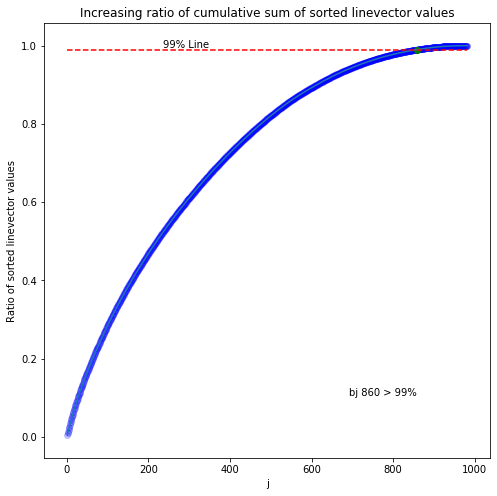

In [819]:
fig, ax = plt.subplots(figsize=krr_radial.f_size)
ax.plot(np.arange(1,sort_linevector_A_best.shape[0]+1),ratio_sorted_lv_A,  '-')
ax.scatter(np.arange(1,sort_linevector_A_best.shape[0]+1),ratio_sorted_lv_A, c='b', alpha=.2)

ax.scatter(a_idx, a, c='green', alpha=1)
ax.plot(range(len(ratio_sorted_lv_A)), [.99]*sort_linevector_A_best.shape[0], 'r--', alpha=1)
ax.text(350,a,'99% Line', horizontalalignment = 'right', verticalalignment = 'bottom')
ax.text(a_idx,.1,'bj {0} > 99%'.format(a_idx+1),
        horizontalalignment = 'right', verticalalignment = 'bottom')

ax.set(title = 'Increasing ratio of cumulative sum of sorted linevector values',
       xlabel = 'j', ylabel = 'Ratio of sorted linevector values')
       
plt.show()

# 4.5. For i =1... m, if |Ai|> THR set AAi = Ai   and otherwise set AAi = 0. This yields a reduced formula 
# PRED(x)  = AA1 K(x, X(1)) + ... + AAm K(x,X(m))


In [820]:
#linevector_A_red = np.where(np.abs(linevector_A_best)>val_threshold,linevector_A_best,0)
linevector_A_red = linevector_A_best.copy()
linevector_A_red[np.abs(linevector_A_red)<val_threshold] = 0 


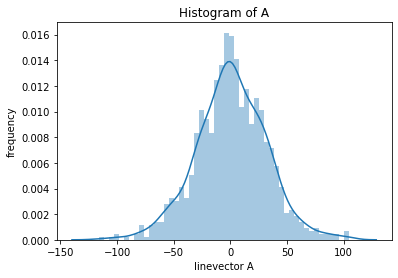

In [821]:
ax = sns.distplot(linevector_A_best,label= 'linevector A ', bins =50)
ax.set(title = 'Histogram of A',
      xlabel = 'linevector A', ylabel = 'frequency')
      #  xticks = np.arange(1,gramian_eig_val.shape[0]+1))
       
plt.show()

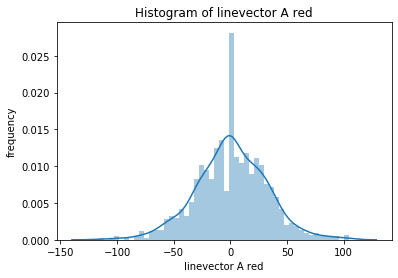

In [822]:
ax = sns.distplot(linevector_A_red, bins =50)
ax.set(title = 'Histogram of linevector A red',
      xlabel = 'linevector A red', ylabel = 'frequency')
      #  xticks = np.arange(1,gramian_eig_val.shape[0]+1))
       
plt.show()

In [823]:
pd.DataFrame(np.asarray(linevector_A_red)[0]).to_excel('linevector_A_red.xlsx')

In [824]:
filepath = 'linevector_comp.xlsx'
with ExcelWriter(filepath) as writer:
    pd.DataFrame(linevector_A_best.T).to_excel(writer,sheet_name = 'linevector_A_best' )
    pd.DataFrame(linevector_A_red.T).to_excel(writer,sheet_name = 'linevector_A_red' )
    writer.save() 

In [825]:
sum(sum(np.asarray(linevector_A_red!=0)))

860

In [826]:
print('number of non-zero Ais in reduced linevector A are: ',sum(sum(np.asarray(linevector_A_red!=0))),
      ' out of ',linevector_A_red.shape[1])

number of non-zero Ais in reduced linevector A are:  860  out of  982


# 4.6. Run this reduced formula on the TRAIN and TEST sets to evaluate its performances


In [827]:
best_params


{'lambda': [0.0197], 'gamma': [0.0017]}

#####performance of reduced linevector on Train data#####


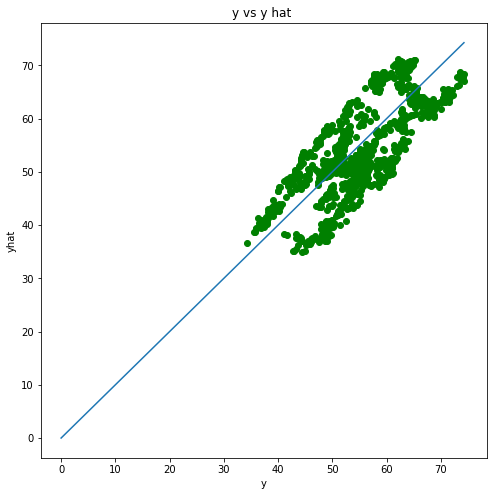

val_rmse:  6.1459
ratio rmse/avy :  0.1129
sigma:  0.0101
For 95% confidence level, confidence interval for ratio 0.1129 is [0.0931, 0.1327]


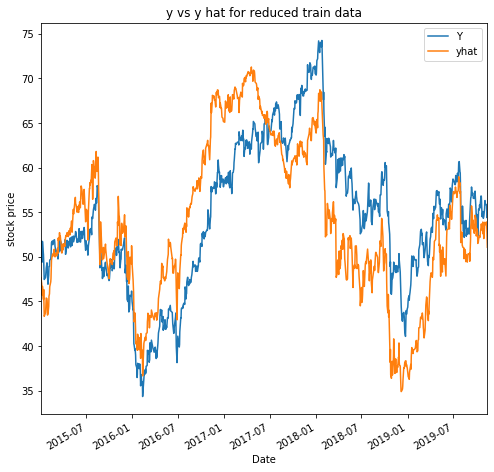

In [828]:
#calc y_predictions for train set for best parameters with reduced linevector A
print('#####performance of reduced linevector on Train data#####')
val_rmse_test,ratio_rmse_avy_test,mat_y_pred_train_red = krr_radial.cal_performance_params(
    best_params['gamma'][0],linevector_A_red,krr_radial.df_train,krr_radial.df_train)

df_train_reduced_lv = krr_radial.df_train.copy()
df_train_reduced_lv['yhat'] = np.asarray(mat_y_pred_train_red.T)

krr_radial.plot_results(df_train_reduced_lv,title= 'y vs y hat for reduced train data')

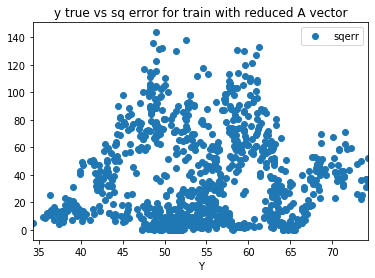

In [829]:
#train data wiht reduced linevector A - true vs error plot
df_train_reduced_lv['sqerr'] = np.asarray(np.square(df_train_reduced_lv['Y']-df_train_reduced_lv['yhat']))
df_train_reduced_lv.plot('Y','sqerr',style='o',title = 'y true vs sq error for train with reduced A vector')


#####performance of reduced linevector on Test data#####


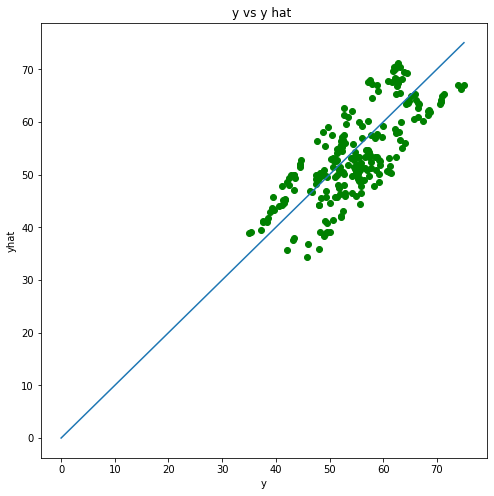

val_rmse:  5.7953
ratio rmse/avy :  0.1067
sigma:  0.0197
For 95% confidence level, confidence interval for ratio 0.1067 is [0.0681, 0.1453]


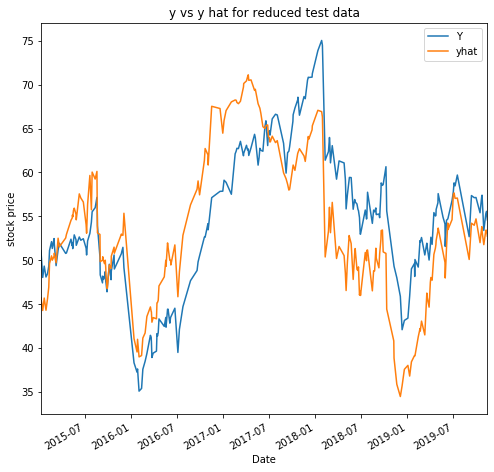

In [830]:
print('#####performance of reduced linevector on Test data#####')
val_rmse_test,ratio_rmse_avy_test,mat_y_pred_test_red = krr_radial.cal_performance_params(
    best_params['gamma'][0],linevector_A_red,krr_radial.df_test,krr_radial.df_train)

df_test_reduced = krr_radial.df_test.copy()
df_test_reduced['yhat'] = np.asarray(mat_y_pred_test_red.T)

krr_radial.plot_results(df_test_reduced,title= 'y vs y hat for reduced test data')

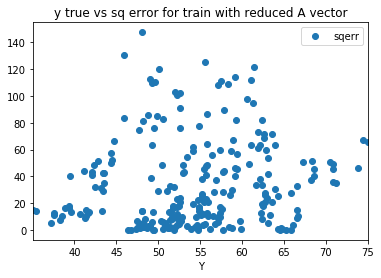

In [831]:
#test data with reduced linevector A - true vs error plot
df_test_reduced['sqerr'] = np.asarray(np.square(df_test_reduced['Y']-df_test_reduced['yhat']))
df_test_reduced.plot('Y','sqerr',style='o',title = 'y true vs sq error for train with reduced A vector')


# 4.7.Compare these performances to the original formula pred(x) and interpret the results



Question 5 (optional): Implement KRR using a pre existing function

# 5.1. using the best parameters found above try to use a pre-existing software function implementing the KRR technique


In [832]:
best_params

{'lambda': [0.0197], 'gamma': [0.0017]}

In [834]:
clf = KernelRidge(alpha=best_params['lambda'][0],kernel = 'rbf',gamma = best_params['gamma'][0])
clf.fit(krr_radial.df_train.loc[:,'X1':'X11'], krr_radial.df_train.loc[:,'Y'])


KernelRidge(alpha=0.0197, coef0=1, degree=3, gamma=0.0017, kernel='rbf',
            kernel_params=None)

###pre-existing model prediction for train data###
rmse_model_train:  0.6152555394212208
ratio rmse/avy:  0.0113
sigma:  0.0034
For 95% confidence level, confidence interval for ratio 0.0113 is [0.0046, 0.018]


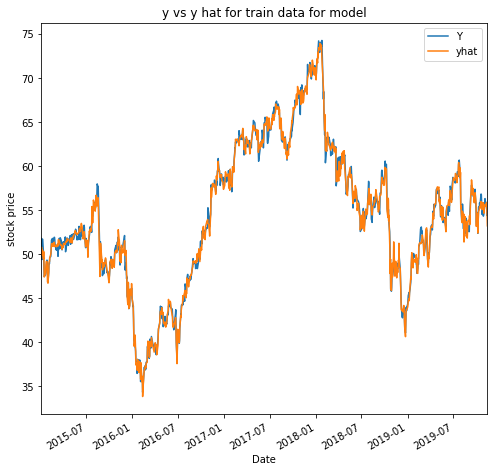

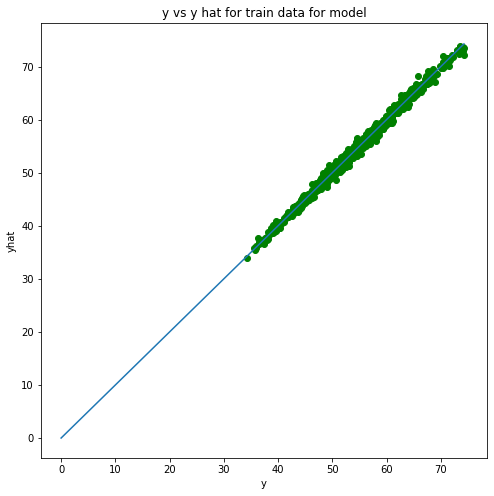

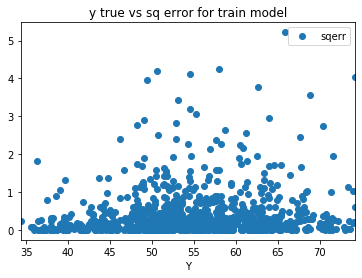

In [835]:
#pre-existing model prediction for train data
print('###pre-existing model prediction for train data###')
pred_y = clf.predict(krr_radial.df_train.loc[:,'X1':'X11'])
rmse_model_train = krr_radial.cal_rmse(krr_radial.df_train.loc[:,'Y'],pred_y)
print('rmse_model_train: ',rmse_model_train)
#print('cal_performance_params variable mat_pred_x:\n',mat_pred_x)
#reshaping arguments for RMSE
mat_y_true = np.asmatrix(krr_radial.df_train['Y'])
mat_y_pred = np.asmatrix(pred_y).reshape(mat_y_true.shape)

#calculate ratio RMSE/avy for test
val_avy_test = np.mean(np.abs(mat_y_true))
ratio_rmse_avy_test = np.around(rmse_model_train/val_avy_test,4)
print('ratio rmse/avy: ',ratio_rmse_avy_test)

confint_ratio_test = krr_radial.err_est_element(ratio_rmse_avy_test,df_train['Y'].shape[0],False)

print('For 95% confidence level, confidence interval for ratio {0} is {1}'.format(ratio_rmse_avy_test,
                                                                                  confint_ratio_test))

df_train_model = krr_radial.df_train.copy()
df_train_model['yhat'] = np.asarray(pred_y)

plot_results(df_train_model,title= 'y vs y hat for train data for model')

#plotting y vs yhat for test for best parameters for reduced LV
xlim = np.min(df_train_model['Y'])
ylim = np.max(df_train_model['Y'])
fig, ax = plt.subplots(figsize=krr_radial.f_size)
ax.plot( [0,ylim],[0,ylim] )
ax.scatter(df_train_model['Y'],df_train_model['yhat'],c = 'g')
ax.set(title = 'y vs y hat for train data for model' , xlabel = 'y', ylabel = 'yhat')
plt.show()

#test data with reduced linevector A - true vs error plot
df_train_model['sqerr'] = np.asarray(np.square(df_train_model['Y']-df_train_model['yhat']))
df_train_model.plot('Y','sqerr',style='o',title = 'y true vs sq error for train model')



###pre-existing model prediction for test data###
rmse:  0.8545383597743481
ratio rmse/avy:  0.0157
sigma:  0.0079
For 95% confidence level, confidence interval for ratio 0.0157 is [0.0002, 0.0312]


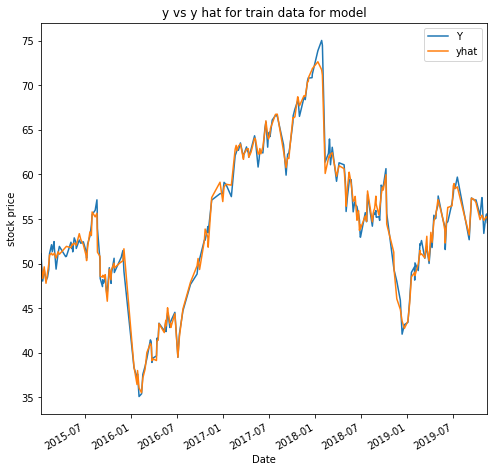

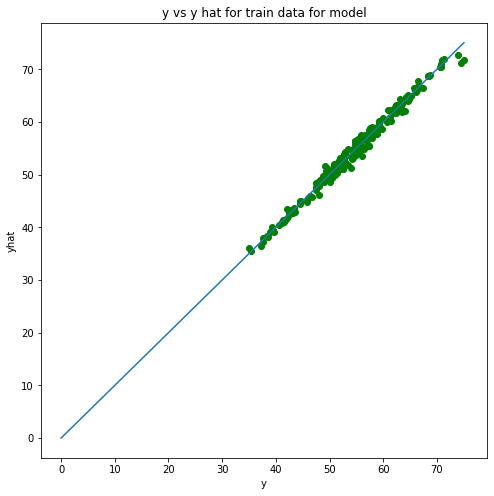

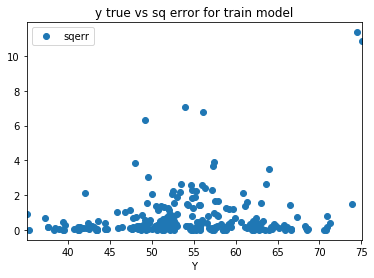

In [836]:
#model prediction for test data
print('###pre-existing model prediction for test data###')
pred_y = clf.predict(krr_radial.df_test.loc[:,'X1':'X11'])
rmse_model_test = krr_radial.cal_rmse(krr_radial.df_test.loc[:,'Y'],pred_y)

#print('cal_performance_params variable mat_pred_x:\n',mat_pred_x)
#reshaping arguments for RMSE
mat_y_true = np.asmatrix(krr_radial.df_test['Y'])
mat_y_pred = np.asmatrix(pred_y).reshape(mat_y_true.shape)

#calculate ratio RMSE/avy for test
val_avy_test = np.mean(np.abs(mat_y_true))
ratio_rmse_avy_test = np.around(rmse_model_test/val_avy_test,4)
print('rmse: ',rmse_model_test)
print('ratio rmse/avy: ',ratio_rmse_avy_test)

confint_ratio_test = krr_radial.err_est_element(ratio_rmse_avy_test,krr_radial.df_test['Y'].shape[0],False)

print('For 95% confidence level, confidence interval for ratio {0} is {1}'.format(ratio_rmse_avy_test,
                                                                                  confint_ratio_test))

df_test_model = krr_radial.df_test.copy()
df_test_model['yhat'] = np.asarray(pred_y)

plot_results(df_test_model,title= 'y vs y hat for train data for model')

#plotting y vs yhat for test for best parameters for reduced LV

ylim = np.max(df_test_model['Y'])
fig, ax = plt.subplots(figsize=krr_radial.f_size)
ax.plot( [0,ylim],[0,ylim] )
ax.scatter(df_test_model['Y'],df_test_model['yhat'],c = 'g')
ax.set(title = 'y vs y hat for train data for model' , xlabel = 'y', ylabel = 'yhat')
plt.show()

#test data with reduced linevector A - true vs error plot
df_test_model['sqerr'] = np.asarray(np.square(df_test_model['Y']-df_test_model['yhat']))
df_test_model.plot('Y','sqerr',style='o',title = 'y true vs sq error for train model')
